# Backtesting & Robustness Analysis

This notebook performs realistic backtesting of the TSMOM and Carry strategies, incorporating transaction costs and turnover analysis. It also evaluates performance across different market regimes and tests the robustness of the strategies to parameter changes.

**Key Analysis:**
1.  **Realistic Backtest:** Gross vs. Net returns with transaction costs (2-5 bps).
2.  **Regime Analysis:** Performance split by Pre-COVID, COVID, and Post-COVID periods.
3.  **Crisis Performance:** Behavior during major market drawdowns.
4.  **Robustness:** Sensitivity to lookback windows and cost assumptions.


In [1]:
import sys
import os
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure src is in path
sys.path.append(os.path.abspath('..'))

from src.portfolio import (
    calculate_ewma_volatility,
    construct_tsmom_portfolio,
    construct_carry_portfolio,
    stack_portfolios
)
from src.backtest import run_backtest
from src.analysis import (
    calculate_return_stats,
    calculate_regime_stats,
    calculate_crisis_performance,
    calculate_max_drawdown
)

# Configure Logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Plotting Style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


## 1. Data Loading & Setup

In [2]:
# Load Data
DATA_DIR = '../data/processed'
signals_path = os.path.join(DATA_DIR, 'master_dataset_with_signals.parquet')
returns_path = os.path.join(DATA_DIR, 'continuous_returns.parquet')

df_signals = pd.read_parquet(signals_path)
df_returns = pd.read_parquet(returns_path)

# Ensure date is datetime
df_signals['date'] = pd.to_datetime(df_signals['date'])
if 'date' in df_returns.columns:
    df_returns['date'] = pd.to_datetime(df_returns['date'])
    df_returns = df_returns.set_index('date')

# Filter for front contracts
if 'is_front' in df_signals.columns:
    df_signals = df_signals[df_signals['is_front']].copy()

# Pivot signals
tsmom_3m = df_signals.pivot(index='date', columns='root', values='tsmom_3m')
tsmom_6m = df_signals.pivot(index='date', columns='root', values='tsmom_6m')
tsmom_12m = df_signals.pivot(index='date', columns='root', values='tsmom_12m')
carry_z = df_signals.pivot(index='date', columns='root', values='carry_z')

# Returns wide
if 'root' in df_returns.columns:
    returns_wide = df_returns.pivot(index='date', columns='root', values='return')
else:
    returns_wide = df_returns

# Asset Class Map
asset_class_map = df_signals[['root', 'asset_class']].drop_duplicates().set_index('root')['asset_class'].to_dict()

# Volatility
from src.portfolio import calculate_ewma_volatility
volatility = calculate_ewma_volatility(returns_wide, lam=0.94)


## 2. Realistic Backtest (with Costs)

TSMOM Turnover: 50.88%
Carry Turnover: 143.96%


/Users/anandtheerthanakhate/Documents/GitHub/tsmom_carry/src/portfolio.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_vol = rolling_vol.replace(0, np.nan).fillna(method='ffill').fillna(target_vol) # Default to no scaling if unknown
/Users/anandtheerthanakhate/Documents/GitHub/tsmom_carry/src/portfolio.py:60: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_vol = rolling_vol.replace(0, np.nan).fillna(method='ffill').fillna(target_vol) # Default to no scaling if unknown


<Figure size 1200x500 with 0 Axes>

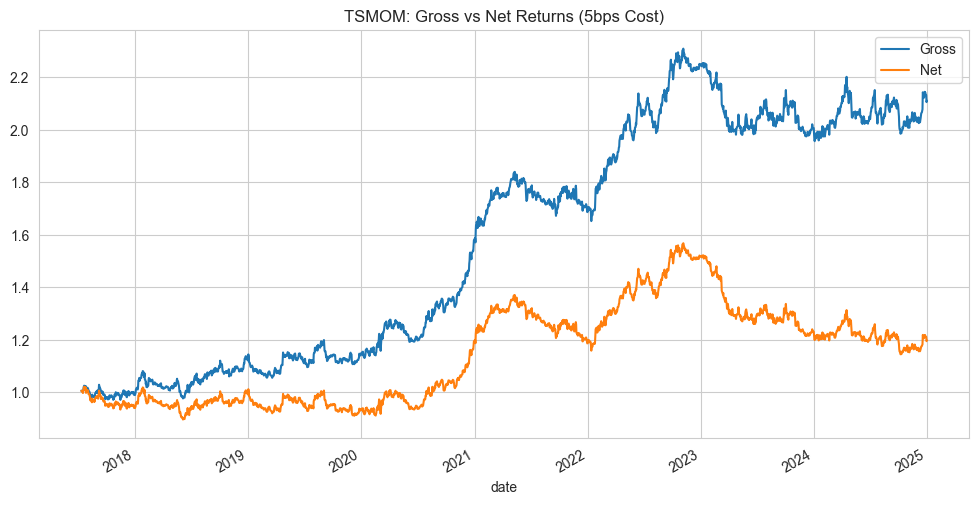

<Figure size 1200x500 with 0 Axes>

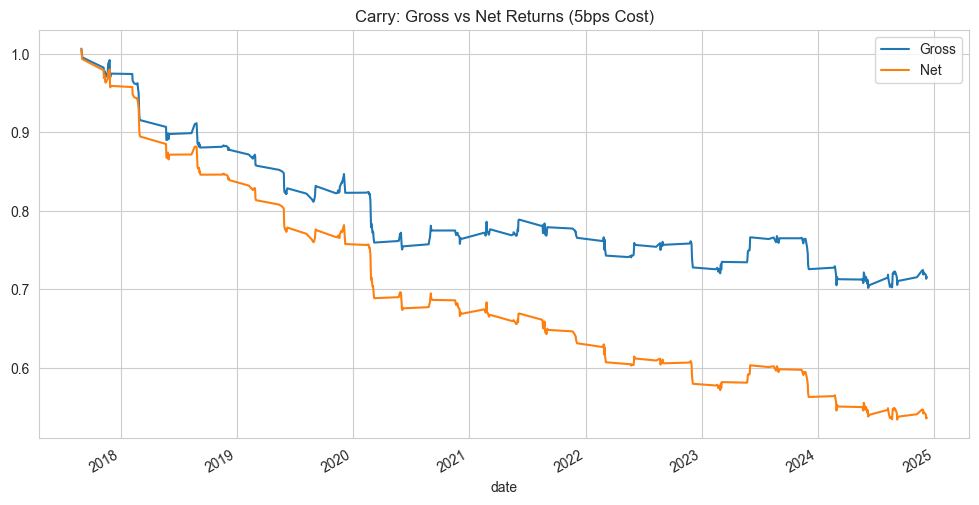

In [3]:
# Construct Portfolios
tsmom_signals = {'3m': tsmom_3m, '6m': tsmom_6m, '12m': tsmom_12m}
tsmom_weights_raw = construct_tsmom_portfolio(tsmom_signals, volatility, target_vol=0.10)
carry_weights_raw = construct_carry_portfolio(carry_z, volatility, asset_class_map, target_vol=0.10)

# Scale to Portfolio Volatility (10%)
# We normalize raw weights (which are asset-level vol scaled) to target portfolio vol
from src.portfolio import scale_portfolio_weights

# FIX: Do NOT divide by n_assets. Let the portfolio be the sum of vol-scaled assets.
# This will have high vol, which we then scale DOWN to target.
tsmom_weights_norm = tsmom_weights_raw
tsmom_weights = scale_portfolio_weights(tsmom_weights_norm, returns_wide, target_vol=0.10)

carry_weights_norm = carry_weights_raw
carry_weights = scale_portfolio_weights(carry_weights_norm, returns_wide, target_vol=0.10)

# Run Backtest with 5bps costs
COST_BPS = 5.0

tsmom_res, tsmom_turnover = run_backtest(tsmom_weights, returns_wide, cost_bps=COST_BPS)
carry_res, carry_turnover = run_backtest(carry_weights, returns_wide, cost_bps=COST_BPS)

print(f"TSMOM Turnover: {tsmom_turnover:.2%}")
print(f"Carry Turnover: {carry_turnover:.2%}")

# Plot Gross vs Net
plt.figure(figsize=(12, 5))
(1 + tsmom_res[['Gross', 'Net']]).cumprod().plot()
plt.title("TSMOM: Gross vs Net Returns (5bps Cost)")
plt.show()

plt.figure(figsize=(12, 5))
(1 + carry_res[['Gross', 'Net']]).cumprod().plot()
plt.title("Carry: Gross vs Net Returns (5bps Cost)")
plt.show()


## 3. Stacked Performance Analysis

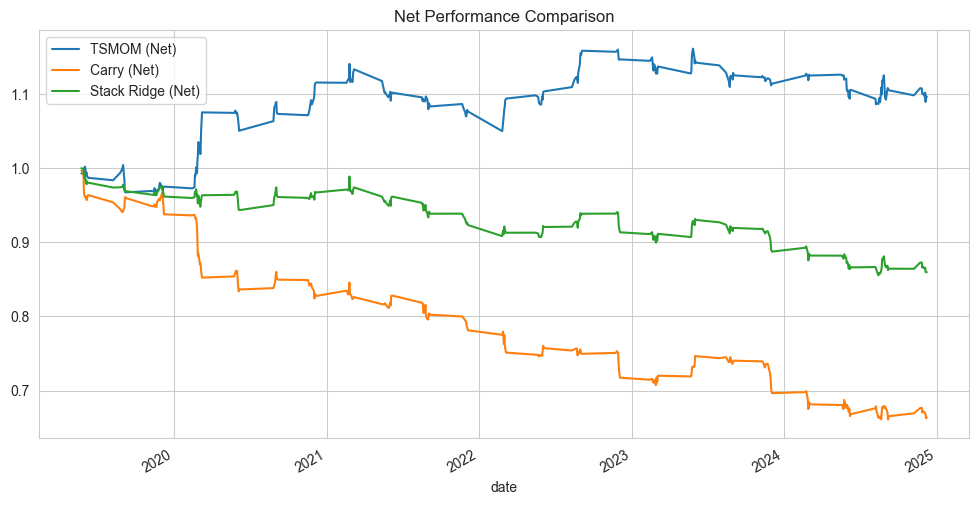

,count,mean,std,min,1%,5%,50%,95%,99%,max,skew,kurt,pct_up,ann_vol,sharpe,max_dd
TSMOM (Net),249.0,0.000391,0.006987,-0.024642,-0.015272,-0.010970,0.000285,0.012290,0.018282,0.021373,0.091436,0.933286,0.514056,0.110917,0.889249,-0.079534
Carry (Net),249.0,-0.001618,0.007320,-0.023873,-0.020850,-0.015125,-0.001171,0.010379,0.015155,0.018093,-0.319096,0.658128,0.417671,0.116201,-3.509170,-0.337033
Stack Ridge (Net),249.0,-0.000593,0.005346,-0.016202,-0.012769,-0.009196,-0.000627,0.008619,0.011469,0.015246,0.118502,0.254671,0.441767,0.084859,-1.759936,-0.144549


In [4]:
# Stack Net Returns
strategy_net_returns = pd.DataFrame({
    'TSMOM': tsmom_res['Net'],
    'Carry': carry_res['Net']
}).dropna()

# Stack using Ridge (Net)
stack_ridge_net = stack_portfolios(strategy_net_returns, method='ridge', window=60, turnover_penalty=0.001)

# Compare
comparison_net = pd.DataFrame({
    'TSMOM (Net)': tsmom_res['Net'],
    'Carry (Net)': carry_res['Net'],
    'Stack Ridge (Net)': stack_ridge_net
}).dropna()

# Cumulative Return
(1 + comparison_net).cumprod().plot(title="Net Performance Comparison")
plt.show()

# Full Stats
display(calculate_return_stats(comparison_net))


## 6. Performance Attribution (Asset Class)

/Users/anandtheerthanakhate/Documents/GitHub/tsmom_carry/src/analysis.py:190: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_contrib = contrib.groupby(group_map, axis=1).sum()


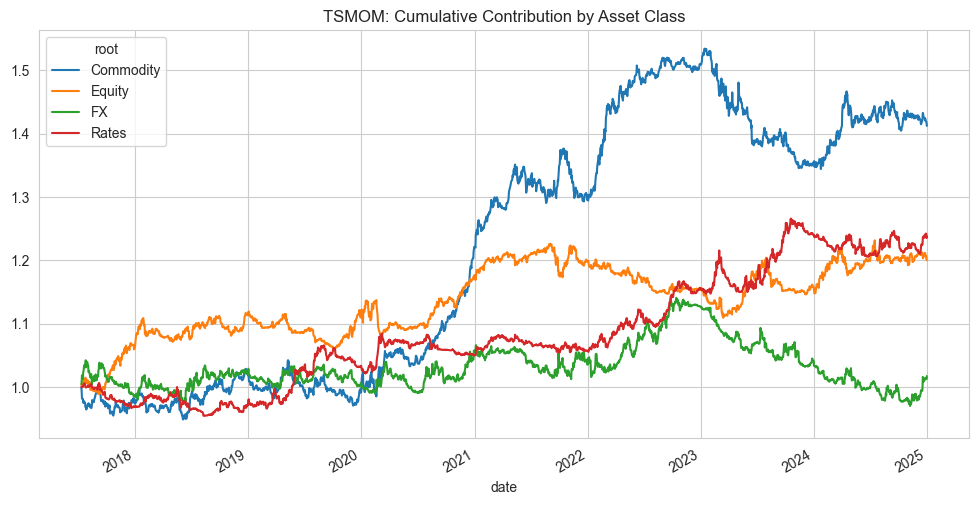

/Users/anandtheerthanakhate/Documents/GitHub/tsmom_carry/src/analysis.py:190: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_contrib = contrib.groupby(group_map, axis=1).sum()


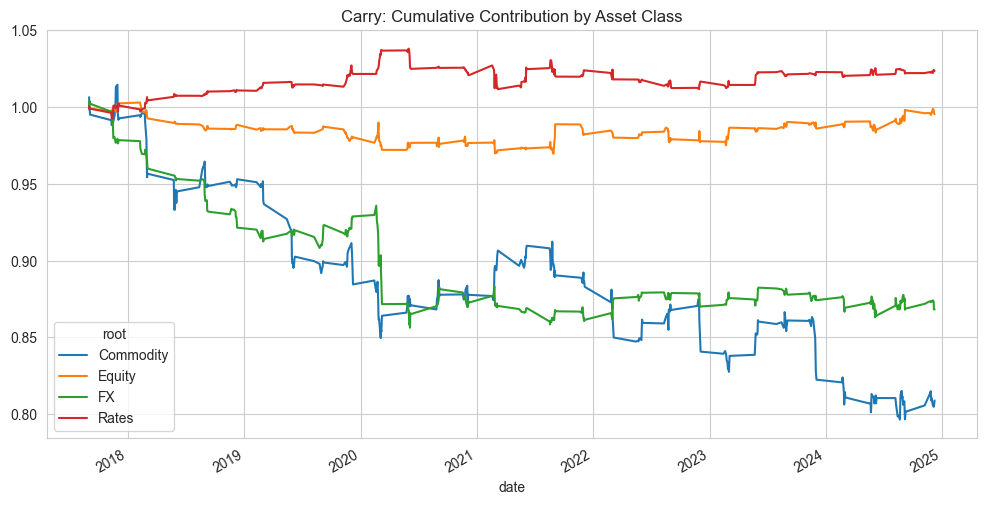

In [5]:
# Asset Class Attribution for TSMOM
from src.analysis import calculate_performance_attribution

tsmom_attrib = calculate_performance_attribution(tsmom_weights, returns_wide, asset_class_map)
(1 + tsmom_attrib).cumprod().plot(title="TSMOM: Cumulative Contribution by Asset Class")
plt.show()

# Asset Class Attribution for Carry
carry_attrib = calculate_performance_attribution(carry_weights, returns_wide, asset_class_map)
(1 + carry_attrib).cumprod().plot(title="Carry: Cumulative Contribution by Asset Class")
plt.show()


## 7. Rolling Sharpe Ratio

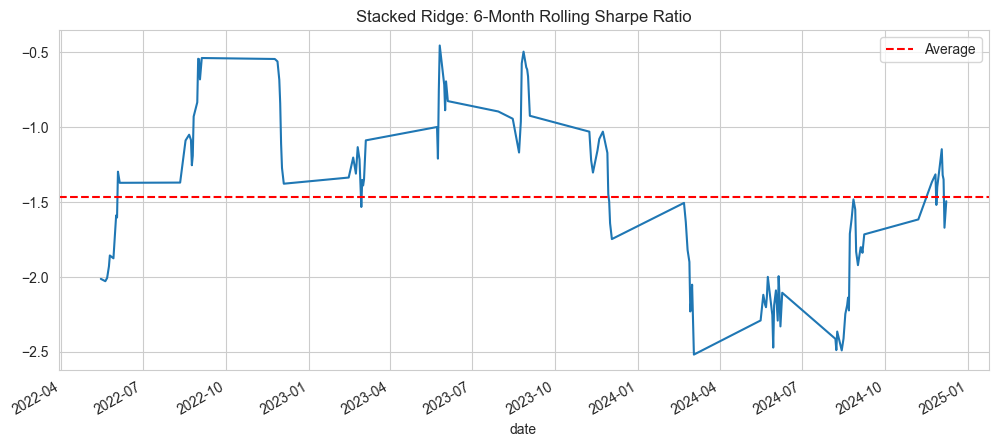

In [6]:
# 6-Month Rolling Sharpe Ratio
rolling_sharpe = stack_ridge_net.rolling(window=126).mean() / stack_ridge_net.rolling(window=126).std() * np.sqrt(252)

plt.figure(figsize=(12, 5))
rolling_sharpe.plot(title="Stacked Ridge: 6-Month Rolling Sharpe Ratio")
plt.axhline(rolling_sharpe.mean(), color='red', linestyle='--', label='Average')
plt.legend()
plt.show()


## 8. Regime Analysis

,count,mean,std,min,1%,5%,50%,95%,99%,max,...,50%,95%,99%,max,skew,kurt,pct_up,ann_vol,sharpe,max_dd
0,32.0,-0.001215,0.003628,-0.008802,-0.008375,-0.007105,-0.000507,0.003826,0.004578,0.004886,...,-0.000746,0.008885,0.012042,0.015246,0.178149,0.351453,0.44,0.086422,-1.917398,-0.134732


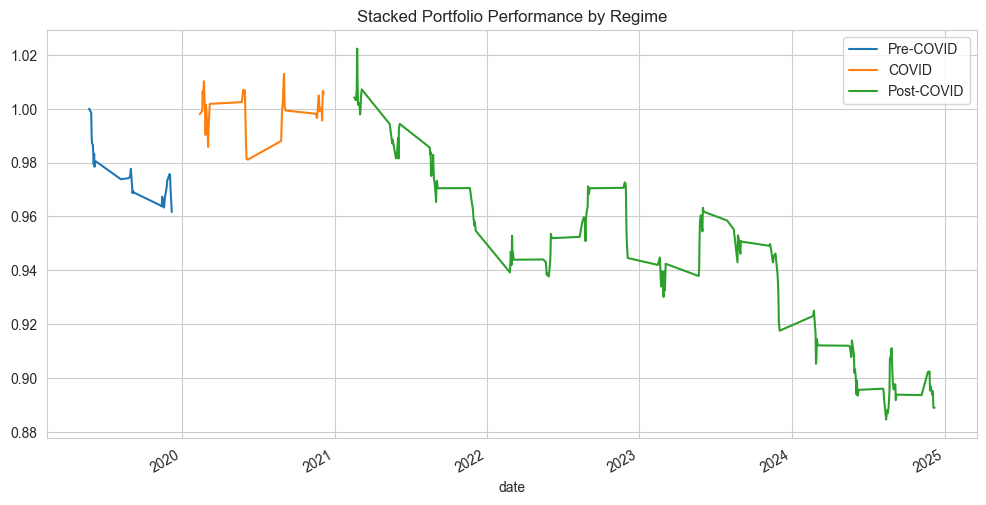

In [7]:
# Define Regimes
regimes = {
    'Pre-COVID': ('2015-01-01', '2019-12-31'),
    'COVID': ('2020-01-01', '2020-12-31'),
    'Post-COVID': ('2021-01-01', '2024-12-31')
}

regime_stats = calculate_regime_stats(stack_ridge_net, regimes)
display(regime_stats)

# Plot Regime Performance
for name, (start, end) in regimes.items():
    mask = (stack_ridge_net.index >= start) & (stack_ridge_net.index <= end)
    if mask.any():
        (1 + stack_ridge_net.loc[mask]).cumprod().plot(label=name)
plt.title("Stacked Portfolio Performance by Regime")
plt.legend()
plt.show()


## 5. Robustness Checks

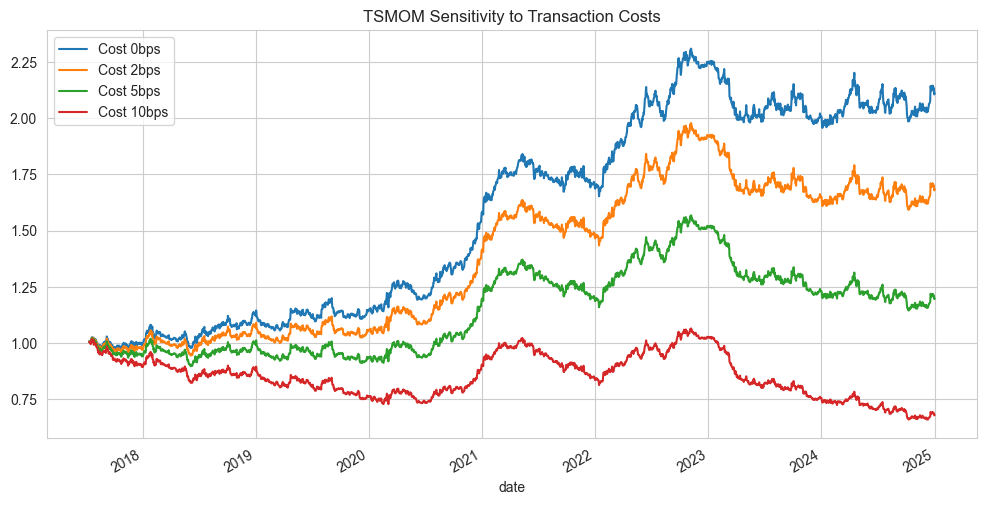

,sharpe,ann_vol,max_dd
Cost 0bps,0.813732,0.106466,-0.152688
Cost 2bps,0.582834,0.106486,-0.194606
Cost 5bps,0.236597,0.106541,-0.269764
Cost 10bps,-0.339456,0.106700,-0.380813


In [8]:
# Sensitivity to Transaction Costs
costs = [0, 2, 5, 10]
results = {}

for c in costs:
    # run_backtest returns (DataFrame, Turnover)
    res_df, _ = run_backtest(tsmom_weights, returns_wide, cost_bps=c)
    results[f'Cost {c}bps'] = res_df['Net']

cost_sensitivity = pd.DataFrame(results).dropna()
(1 + cost_sensitivity).cumprod().plot(title="TSMOM Sensitivity to Transaction Costs")
plt.show()

display(calculate_return_stats(cost_sensitivity)[['sharpe', 'ann_vol', 'max_dd']])
